In [41]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

## Election Results

Election results from Nevada Secretary of State (https://www.nvsos.gov/sos/elections/election-information/precinct-level-results).

## Shape Files
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. The following counties used shapefiles sourced from the respective county governments instead: Clark, Douglas, Elko, Humboldt, Lincoln, Lyon, Washoe.

County borders in all county-sourced shapefiles were aligned to the U.S Census Bureau's boundaries. Minor adjustments were made in the Precinct 1/3 boundary of Eureka County and in the Precinct 6/5 boundary of Pershing County to match county GIS maps. Substantial revisions were made in the Fallon area of Churchill County and in the Tonopah area of Nye County to match county PDF maps.

## Processing
Countywide-reported votes for Carson City, Churchill, Clark, Douglas, Elko, Humboldt, Lyon, Nye, Pershing, Washoe, and White Pine were distributed by candidate based on the precinct-level reported vote. Clark County had congressional district-reported votes that were distributed accordingly.

The state election results by precinct do not include precinct votes by candidate for precincts with less than 10 total votes cast. For Douglas and Washoe, these were transferred from the county precinct reports. For Churchill, Elko, Esmeralda, Humboldt, Lyon, Mineral, Nye, Pershing, Storey, and White Pine these were inferred from the countywide totals. Clark County was also inferred from countywide totals, but using additional party registration information as of Nov 5, 2016 with slight adjustments to match total ballots cast per precinct.


## Races

 - G16PREDCLI - Hillary Clinton (Democratic Party)
 - G16PRERTRU - Donald J. Trump (Republican Party)
 - G16PRELJOH - Gary Johnson (Libertarian Party)
 - G16PREICAS - Darrell L. Castle (Independent American Party)
 - G16PRENROC - Roque "Rocky" De La Fuente (No Political Party)
 - G16PREONON - None of These Candidates

 - G16USSDCOR - Catherine Cortez Masto (Democratic Party)
 - G16USSRHEC - Joe Heck (Republican Party)
 - G16USSIJON - Tom Jones (Independent American Party)
 - G16USSNSAW - Thomas "Tom" Sawyer (No Political Party)
 - G16USSNGUM - Tony Gumina (No Political Party)
 - G16USSNWIL - Jarrod M. Williams (No Political Party)
 - G16USSONON - None of These Candidates



In [42]:
vest_shp = gp.read_file("./raw-from-source/vest/nv_2016.shp")

In [43]:
vest_shp.shape

(2067, 16)

In [44]:
vest_shp.head()

,COUNTYFP,NAME,G16PREDCLI,G16PRERTRU,G16PRELJOH,G16PREICAS,G16PRENROC,G16PREONON,G16USSDCOR,G16USSRHEC,G16USSIJON,G16USSNSAW,G16USSNGUM,G16USSNWIL,G16USSONON,geometry
0,015,Precinct No. 1 - Argenta,81,277,14,2,1,18,83,268,6,4,2,6,22,"POLYGON Z ((-116.94496 40.63541 0.00000, -116...."
1,015,Precinct No. 2 - Argenta,107,328,23,3,2,15,101,309,16,11,3,6,26,"POLYGON Z ((-117.01865 40.99900 0.00000, -117...."
2,015,Precinct No. 3 - Argenta,25,107,0,0,1,4,25,92,2,5,1,2,10,"POLYGON Z ((-116.93441 40.64533 0.00000, -116...."
3,015,Precinct No. 4 - Argenta,66,483,14,4,1,14,77,444,12,9,8,4,19,"POLYGON Z ((-117.19382 40.01957 0.00000, -117...."
4,015,Precinct No. 5 - Argenta,86,413,18,4,3,18,88,381,11,16,7,9,29,"POLYGON Z ((-117.53986 40.00510 0.00000, -117...."


<AxesSubplot:>

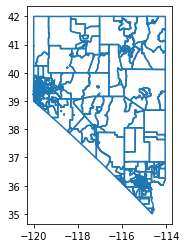

In [45]:
vest_shp.boundary.plot()

<AxesSubplot:>

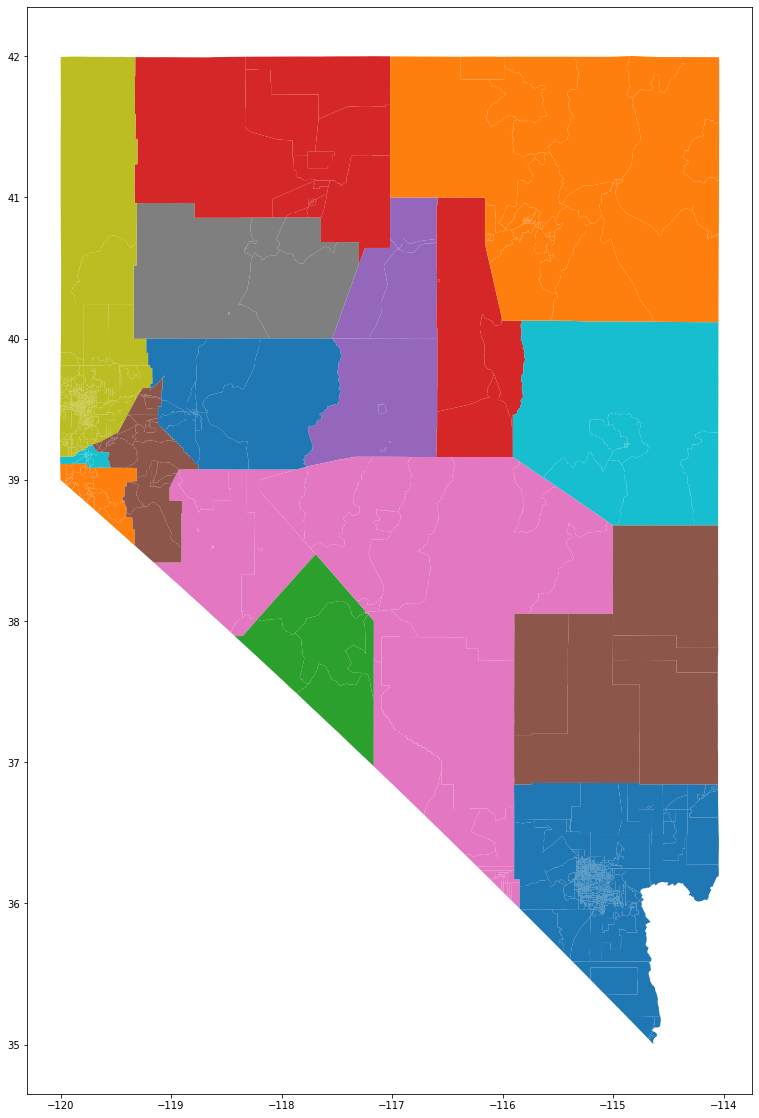

In [46]:
vest_shp.plot(column='COUNTYFP', figsize=(20,20))

In [47]:
vest_shp.columns

Index(['COUNTYFP', 'NAME', 'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREICAS', 'G16PRENROC', 'G16PREONON', 'G16USSDCOR', 'G16USSRHEC',
       'G16USSIJON', 'G16USSNSAW', 'G16USSNGUM', 'G16USSNWIL', 'G16USSONON',
       'geometry'],
      dtype='object')

In [48]:

vest_shp = vest_shp.iloc[:,:-1]


## Load the SOS Election Results File

In [49]:
nv_16 = pd.read_csv("./raw-from-source/source/2016 General Election Results (CSV Format).csv", index_col=False)

In [50]:
nv_16.head()

,Jurisdiction,Precinct,Contest,Selection,Votes
0,Carson City,Precinct 101,COUNTY QUESTION CC1,No,520
1,Carson City,Precinct 101,COUNTY QUESTION CC1,Yes,317
2,Carson City,Precinct 101,"Court Of Appeals Judge, Dept. 1",None Of These Candidates,193
3,Carson City,Precinct 101,"Court Of Appeals Judge, Dept. 1","TAO, JERRY",553
4,Carson City,Precinct 101,"Court Of Appeals Judge, Dept. 2","GIBBONS, MICHAEL",586


In [51]:
nv_16.shape

(105429, 5)

In [52]:
nv_16

,Jurisdiction,Precinct,Contest,Selection,Votes
0,Carson City,Precinct 101,COUNTY QUESTION CC1,No,520
1,Carson City,Precinct 101,COUNTY QUESTION CC1,Yes,317
2,Carson City,Precinct 101,"Court Of Appeals Judge, Dept. 1",None Of These Candidates,193
3,Carson City,Precinct 101,"Court Of Appeals Judge, Dept. 1","TAO, JERRY",553
4,Carson City,Precinct 101,"Court Of Appeals Judge, Dept. 2","GIBBONS, MICHAEL",586
...,...,...,...,...,...
105424,White Pine,Precinct 99,United States Senator,"HECK, JOE",2
105425,White Pine,Precinct 99,United States Senator,"JONES, TOM",0
105426,White Pine,Precinct 99,United States Senator,None Of These Candidates For Senate,0
105427,White Pine,Precinct 99,United States Senator,"SAWYER, THOMAS ""TOM""",0


## Clean Up the Elections Results

In [53]:
#filter rows with presidential, Senatorial, and Corporate Commissioner results
filtered_16 = nv_16.loc[(nv_16['Contest']== 'President and Vice President of the United States') | (nv_16['Contest']== 'United States Senator')]
filtered_16.reset_index(drop=True, inplace = True)
#filtered_20.to_csv('filtered.csv')
nv_16['Contest'].value_counts()

United States Senator                                13895
President and Vice President of the United States    12018
STATE QUESTION NO.3                                   3926
Court Of Appeals Judge, Dept. 3                       3926
Court Of Appeals Judge, Dept. 2                       3926
                                                     ...  
Kingston Town Board, Seat E                              1
Lander Sewer & Water Dist. 2, Seat B                     1
Lander Sewer & Water Dist. 2, Seat D                     1
Kingston Town Board, Seat A                              1
Kingston Town Board, Seat C                              1
Name: Contest, Length: 215, dtype: int64

## Identify Low Vote Precincts

In [54]:
filtered_16[filtered_16['Votes']=="*"]["Jurisdiction"].unique()

array(['Clark'], dtype=object)

In [55]:
filtered_16[filtered_16['Votes']=="*"].shape


(832, 5)

768 Precincts with hidden votes due to Nevada State Law requiring precincts with less than 10 votes to be denoted with an * asterisk to protect voter confidentiality. All counties with differences in the validation section of this report match the precincts with *'s above. XXX precincts have an election difference while 768 precincts have an asterisk. 

In [56]:
filtered_16

,Jurisdiction,Precinct,Contest,Selection,Votes
0,Carson City,Precinct 101,President and Vice President of the United States,"CASTLE, DARRELL",5
1,Carson City,Precinct 101,President and Vice President of the United States,"CLINTON, HILLARY",354
2,Carson City,Precinct 101,President and Vice President of the United States,"DE LA FUENTE, ROQUE ""ROCKY""",3
3,Carson City,Precinct 101,President and Vice President of the United States,"JOHNSON, GARY",39
4,Carson City,Precinct 101,President and Vice President of the United States,None Of These Candidates For President and Vic...,39
...,...,...,...,...,...
25908,White Pine,Precinct 99,United States Senator,"HECK, JOE",2
25909,White Pine,Precinct 99,United States Senator,"JONES, TOM",0
25910,White Pine,Precinct 99,United States Senator,None Of These Candidates For Senate,0
25911,White Pine,Precinct 99,United States Senator,"SAWYER, THOMAS ""TOM""",0


In [57]:
#drop columns with asterisks for now
filtered_16['Votes'] = filtered_16['Votes'].replace(to_replace=r'\*', value='0', regex=True)
filtered_16['Votes'] = filtered_16['Votes'].astype(int)

<ipython-input-57-d27c1a39303e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_16['Votes'] = filtered_16['Votes'].replace(to_replace=r'\*', value='0', regex=True)
<ipython-input-57-d27c1a39303e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_16['Votes'] = filtered_16['Votes'].astype(int)


In [58]:
#Creating unique values for None Of These Candidates for each race
df_filtered_senate = filtered_16[(filtered_16['Selection']=='None Of These Candidates')]
df_filtered_senate1 = df_filtered_senate[((df_filtered_senate["Contest"]=='United States Senator'))]
df_filtered_senate1['Selection'] = df_filtered_senate1['Selection'].str.replace('None Of These Candidates','None Of These Candidates For Senate')

#Creating unique values for None Of These Candidates for each race
df_filtered_pres= filtered_16[(filtered_16['Selection']=='None Of These Candidates')]
df_filtered_pres1 = df_filtered_pres[((df_filtered_pres["Contest"]=='President and Vice President of the United States'))]
df_filtered_pres1['Selection'] = df_filtered_pres1['Selection'].str.replace('None Of These Candidates','None Of These Candidates For President and Vice President')

filtered_16.update(df_filtered_senate1, join='left')
filtered_16.update(df_filtered_pres1, join='left')


In [59]:
pivot_df = pd.pivot_table(filtered_16, index = ['Precinct','Jurisdiction'], columns = 'Selection', values='Votes')

pivot_df = pivot_df.rename(columns={'CASTLE, DARRELL':'G16PREICAS','CLINTON, HILLARY':'G16PREDCLI','JOHNSON, GARY':'G16PRELJOH','DE LA FUENTE, ROQUE "ROCKY"':'G16PRENROC','None Of These Candidates For President and Vice President':'G16PREONON','CORTEZ MASTO, CATHERINE':'G16USSDCOR','HECK, JOE':'G16USSRHEC','JONES, TOM':'G16USSIJON','SAWYER, THOMAS "TOM"':'G16USSNSAW','GUMINA, TONY':'G16USSNGUM','WILLIAMS, JARROD M.':'G16USSNWIL','None Of These Candidates For Senate':'G16USSONON','TRUMP, DONALD J.':'G16PRERTRU'})
pivot_df = pivot_df[["G16PREDCLI","G16PRERTRU","G16PRELJOH","G16PREICAS","G16PRENROC","G16PREONON","G16USSDCOR","G16USSRHEC","G16USSIJON","G16USSNSAW","G16USSNGUM","G16USSNWIL","G16USSONON"]]
pivot_df.reset_index(inplace=True)

In [60]:
#uploading national FIPS codes to apply back to file
FIPS = pd.read_csv('./raw-from-source/FIPS/US_FIPS_Codes.csv')
FIPS = FIPS[FIPS['State'] == 'Nevada']
FIPS1 = FIPS.drop(['State','FIPS State'],axis=1)

#adding leading zeroes to FIPS data
FIPS1['FIPS County'] = FIPS1['FIPS County'].apply(lambda x:'{0:0>3}'.format(x))
FIPS1['Jurisdiction'] = FIPS1['County Name']
FIPS1.reset_index(inplace=True)
FIPS1 = FIPS1.drop(['index'],axis=1)
FIPS1 = FIPS1.iloc[: , 1:]

#lower case all precinct names and merge with county fps
pivot_df['Precinct'] = pivot_df['Precinct'].str.lower()
pivot_df = pivot_df.merge(FIPS1, how='left', on='Jurisdiction')

vest_shp['FIPS County'] = vest_shp['COUNTYFP']
vest_shp = vest_shp.merge(FIPS1, how='left', on='FIPS County')

In [61]:
#remove non-alphanumeric characters
def alphanum(element):
    
    return "".join(filter(str.isalnum, element))
pivot_df.loc[:,'NAME'] = [alphanum(x) for x in pivot_df['Precinct']]
pivot_df['unq_id'] = pivot_df["FIPS County"] + " " + pivot_df["Precinct"]

In [62]:
#creating a unique id out of precinct name and county fp

vest_shp['NAME'] = vest_shp['NAME'].str.lower()
vest_shp['NAME'] = vest_shp['NAME'].astype(str)
vest_shp.loc[:,'NAME'] = [alphanum(x) for x in vest_shp['NAME']]
vest_shp['unq_id'] = vest_shp["COUNTYFP"] + " " + vest_shp["NAME"]

In [63]:
#join on unique id lots of unmatched places

join_1 = pd.merge(pivot_df, vest_shp, how="outer",on='unq_id', indicator = True, validate="1:1")
join_1["_merge"].value_counts()

right_only    1502
left_only     1438
both           565
Name: _merge, dtype: int64

## Validate Elections Results

In [64]:
#statewide vote total check
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [65]:
column_list = ["G16PREDCLI","G16PRERTRU","G16PRELJOH","G16PREICAS","G16PRENROC","G16PREONON","G16USSDCOR","G16USSRHEC","G16USSIJON","G16USSNSAW","G16USSNGUM","G16USSNWIL","G16USSONON"]
statewide_totals_check(vest_shp,pivot_df,column_list)

***Statewide Totals Check***
G16PREDCLI is equal 	VEST / RDH: 539260
G16PRERTRU is equal 	VEST / RDH: 512058
G16PRELJOH is equal 	VEST / RDH: 37384
G16PREICAS is equal 	VEST / RDH: 5268
G16PRENROC is equal 	VEST / RDH: 2552
G16PREONON is equal 	VEST / RDH: 28863
G16USSDCOR is equal 	VEST / RDH: 521994
G16USSRHEC is equal 	VEST / RDH: 495079
G16USSIJON is equal 	VEST / RDH: 17128
G16USSNSAW is equal 	VEST / RDH: 14208
G16USSNGUM is equal 	VEST / RDH: 10740
G16USSNWIL is equal 	VEST / RDH: 6888
G16USSONON is equal 	VEST / RDH: 42257


In [66]:
#Checks county level results
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [67]:
#county_col = name of counties needed to compare
county_totals_check(vest_shp, pivot_df,column_list, "Jurisdiction")

***Countywide Totals Check***

G16PREDCLI is equal across all counties
G16PRERTRU is equal across all counties
G16PRELJOH is equal across all counties
G16PREICAS is equal across all counties
G16PRENROC is equal across all counties
G16PREONON is equal across all counties
G16USSDCOR is equal across all counties
G16USSRHEC is equal across all counties
G16USSIJON is equal across all counties
G16USSNSAW is equal across all counties
G16USSNGUM is equal across all counties
G16USSNWIL is equal across all counties
G16USSONON is equal across all counties


## Allocating Countywide Votes

In [68]:
#Allocate Absentee Precincts
def allocate_presidential(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial a|llocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [90]:
pivot_df = pivot_df.dropna()
absentee_votes = pivot_df[pivot_df["unq_id"].isin(["031 9600",
"031 9700",
"031 9800",
"031 9900",
"003 9991  pro",
"003 9993  pro",
"003 9994  pro",
"003 9995  chal",
"003 9996  county",
"021 precinct 88",
"027 precinct 88",
"029 precinct 88",
"021 precinct 99",
"027 precinct 99",
"029 precinct 99",
"001 precinct 88",
"005 precinct 88",
"007 precinct 88",
"009 precinct 88",
"011 precinct 88",
"013 precinct 88",
"015 precinct 88",
"017 precinct 88",
"019 precinct 88",
"023 precinct 88",
"033 precinct 88",
"001 precinct 99",
"005 precinct 99",
"007 precinct 99",
"009 precinct 99",
"011 precinct 99",
"013 precinct 99",
"015 precinct 99",
"017 precinct 99",
"019 precinct 99",
"023 precinct 99",
"033 precinct 99",
"510 precinct 997",
"510 precinct 998",
"510 precinct 999"])]
precinct_votes = pivot_df[~pivot_df["unq_id"].isin(["031 9600",
"031 9700",
"031 9800",
"031 9900",
"003 9991  pro",
"003 9993  pro",
"003 9994  pro",
"003 9995  chal",
"003 9996  county",
"021 precinct 88",
"027 precinct 88",
"029 precinct 88",
"021 precinct 99",
"027 precinct 99",
"029 precinct 99",
"001 precinct 88",
"005 precinct 88",
"007 precinct 88",
"009 precinct 88",
"011 precinct 88",
"013 precinct 88",
"015 precinct 88",
"017 precinct 88",
"019 precinct 88",
"023 precinct 88",
"033 precinct 88",
"001 precinct 99",
"005 precinct 99",
"007 precinct 99",
"009 precinct 99",
"011 precinct 99",
"013 precinct 99",
"015 precinct 99",
"017 precinct 99",
"019 precinct 99",
"023 precinct 99",
"033 precinct 99",
"510 precinct 997",
"510 precinct 998",
"510 precinct 999"])]
allocated_df = allocate_presidential(precinct_votes, absentee_votes, column_list,"FIPS County")


C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,Precinct,Jurisdiction,G16PREDCLI,G16PRERTRU,G16PRELJOH,G16PREICAS,G16PRENROC,G16PREONON,G16USSDCOR,G16USSRHEC,G16USSIJON,G16USSNSAW,G16USSNGUM,G16USSNWIL,G16USSONON,FIPS County,NAME,unq_id
0,01-centerville,Douglas,155,467,9,1,2,23,154,471,5,1,1,0,22,005,01centerville,005 01-centerville
1,02-fish springs,Douglas,297,774,36,6,4,43,300,784,14,9,5,6,30,005,02fishsprings,005 02-fish springs
2,03-gardnerville,Douglas,332,536,35,3,5,36,327,525,15,12,10,4,38,005,03gardnerville,005 03-gardnerville
3,04-carson valley estates,Douglas,207,434,25,0,2,19,199,435,8,10,2,3,25,005,04carsonvalleyestates,005 04-carson valley estates
4,05-genoa,Douglas,184,498,32,0,0,27,180,525,8,3,7,1,14,005,05genoa,005 05-genoa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,tonopah 15,Nye,7,21,2,0,0,7,12,18,1,0,1,1,3,023,tonopah15,023 tonopah 15
1999,west mason valley 1,Lyon,178,418,9,4,2,11,185,385,12,8,4,2,22,019,westmasonvalley1,019 west mason valley 1
2000,west mason valley 2,Lyon,61,259,8,3,2,14,60,256,12,5,2,2,6,019,westmasonvalley2,019 west mason valley 2
2001,west mason valley 3,Lyon,17,23,0,0,1,3,13,26,1,1,0,0,3,019,westmasonvalley3,019 west mason valley 3


In [70]:
#absentee_votes = allocated_df[allocated_df["unq_id"].isin(["003 placeholder prec"])]
#precinct_votes = allocated_df[~allocated_df["unq_id"].isin(["003 placeholder prec"])]

#testallocation = allocate_presidential(precinct_votes, absentee_votes, column_list,"FIPS County")

In [ ]:
#Clark County Allocation
absentee_votes = allocated_df[allocated_df["unq_id"].isin(["003 placeholder prec"])]
precinct_votes = allocated_df[allocated_df["unq_id"].isin([
"003 1309 - county",
"003 1361 - county",
"003 1365 - county",
"003 1371 - county",
"003 1374 - county",
"003 1376 - county",
"003 1377 - county",
"003 1378 - county",
"003 1380 - county",
"003 1381 - county",
"003 1386 - county",
"003 1533 - county",
"003 1644 - county",
"003 1685 - county",
"003 1711 - hen",
"003 2078 - county",
"003 2401 - county",
"003 2405 - county",
"003 2406 - county",
"003 2407 - county",
"003 2408 - county",
"003 2436 - county",
"003 2447 - nlv",
"003 2458 - county",
"003 2503 - county",
"003 2601 - county",
"003 2609 - county",
"003 2623 - county",
"003 2625 - county",
"003 2641 - las",
"003 2664 - las",
"003 2681 - county",
"003 2683 - county",
"003 2685 - county",
"003 2694 - county",
"003 2703 - county",
"003 2712 - county",
"003 2715 - nlv",
"003 3191 - county",
"003 3433 - county",
"003 3439 - county",
"003 3457 - county",
"003 3559 - county",
"003 3566 - las",
"003 3571 - county",
"003 3579 - county",
"003 3581 - county",
"003 3582 - county",
"003 3700 - las",
"003 3712 - county",
"003 3725 - county",
"003 3731 - county",
"003 3744 - county",
"003 3753 - las",
"003 3777 - county",
"003 3823 - county",
"003 3825 - county",
"003 3832 - las",
"003 4076 - county",
"003 4454 - county",
"003 4572 - county",
"003 4594 - nlv",
"003 4613 - las",
"003 4636 - las",
"003 4637 - las",
"003 4651 - nlv",
"003 5014 - las",
"003 6484 - county",
"003 6614 - county",
"003 6722 - county",
"003 7745 - county"])]
print(precinct_votes)

final_allocation = allocate_presidential(precinct_votes, absentee_votes, column_list,"FIPS County")

In [91]:
allocated_df.update(final_allocation, join='left')

C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


## Dictionary Join

In [92]:
source_to_vest = {"001 churchillprecinct01":"001 precinct 01",
"001 churchillprecinct02":"001 precinct 02",
"001 churchillprecinct03":"001 precinct 03",
"001 churchillprecinct04":"001 precinct 04",
"001 churchillprecinct05":"001 precinct 05",
"001 churchillprecinct06":"001 precinct 06",
"001 churchillprecinct07":"001 precinct 07",
"001 churchillprecinct08":"001 precinct 08",
"001 churchillprecinct09":"001 precinct 09",
"001 churchillprecinct10":"001 precinct 10",
"001 churchillprecinct11":"001 precinct 11",
"001 churchillprecinct12":"001 precinct 12",
"001 churchillprecinct13":"001 precinct 13",
"001 churchillprecinct14":"001 precinct 14",
"001 churchillprecinct15":"001 precinct 15",
"001 churchillprecinct16":"001 precinct 16",
"001 churchillprecinct17":"001 precinct 17",
"001 churchillprecinct18":"001 precinct 18",
"001 churchillprecinct19":"001 precinct 19",
"003 1038":"003 1038 - county",
"003 1039":"003 1039 - county",
"003 1063":"003 1063 - county",
"003 1067":"003 1067 - county",
"003 1072":"003 1072 - county",
"003 1074":"003 1074 - county",
"003 1137":"003 1137 - county",
"003 1302":"003 1302 - county",
"003 1303":"003 1303 - county",
"003 1304":"003 1304 - county",
"003 1307":"003 1307 - county",
"003 1309":"003 1309 - county",
"003 1318":"003 1318 - county",
"003 1327":"003 1327 - county",
"003 1328":"003 1328 - county",
"003 1330":"003 1330 - county",
"003 1331":"003 1331 - county",
"003 1332":"003 1332 - county",
"003 1333":"003 1333 - county",
"003 1334":"003 1334 - county",
"003 1335":"003 1335 - county",
"003 1336":"003 1336 - county",
"003 1337":"003 1337 - county",
"003 1340":"003 1340 - county",
"003 1341":"003 1341 - county",
"003 1342":"003 1342 - county",
"003 1343":"003 1343 - county",
"003 1344":"003 1344 - county",
"003 1345":"003 1345 - county",
"003 1346":"003 1346 - county",
"003 1348":"003 1348 - county",
"003 1349":"003 1349 - county",
"003 1351":"003 1351 - county",
"003 1352":"003 1352 - county",
"003 1353":"003 1353 - county",
"003 1354":"003 1354 - county",
"003 1356":"003 1356 - county",
"003 1361":"003 1361 - county",
"003 1363":"003 1363 - county",
"003 1365":"003 1365 - county",
"003 1367":"003 1367 - county",
"003 1368":"003 1368 - county",
"003 1370":"003 1370 - county",
"003 1371":"003 1371 - county",
"003 1374":"003 1374 - county",
"003 1375":"003 1375 - county",
"003 1376":"003 1376 - county",
"003 1377":"003 1377 - county",
"003 1378":"003 1378 - county",
"003 1379":"003 1379 - county",
"003 1380":"003 1380 - county",
"003 1381":"003 1381 - county",
"003 1382":"003 1382 - county",
"003 1384":"003 1384 - hen",
"003 1385":"003 1385 - county",
"003 1386":"003 1386 - county",
"003 1387":"003 1387 - county",
"003 1389":"003 1389 - hen",
"003 1390":"003 1390 - hen",
"003 1391":"003 1391 - hen",
"003 1394":"003 1394 - hen",
"003 1395":"003 1395 - hen",
"003 1396":"003 1396 - hen",
"003 1410":"003 1410 - hen",
"003 1411":"003 1411 - hen",
"003 1509":"003 1509 - hen",
"003 1510":"003 1510 - hen",
"003 1511":"003 1511 - hen",
"003 1513":"003 1513 - hen",
"003 1514":"003 1514 - hen",
"003 1517":"003 1517 - hen",
"003 1518":"003 1518 - hen",
"003 1519":"003 1519 - hen",
"003 1520":"003 1520 - hen",
"003 1521":"003 1521 - hen",
"003 1525":"003 1525 - hen",
"003 1528":"003 1528 - hen",
"003 1533":"003 1533 - county",
"003 1550":"003 1550 - hen",
"003 1552":"003 1552 - hen",
"003 1553":"003 1553 - hen",
"003 1601":"003 1601 - county",
"003 1602":"003 1602 - county",
"003 1603":"003 1603 - county",
"003 1604":"003 1604 - county",
"003 1605":"003 1605 - county",
"003 1606":"003 1606 - hen",
"003 1607":"003 1607 - county",
"003 1608":"003 1608 - hen",
"003 1609":"003 1609 - county",
"003 1611":"003 1611 - county",
"003 1612":"003 1612 - county",
"003 1613":"003 1613 - county",
"003 1614":"003 1614 - county",
"003 1615":"003 1615 - county",
"003 1616":"003 1616 - county",
"003 1617":"003 1617 - county",
"003 1618":"003 1618 - county",
"003 1619":"003 1619 - county",
"003 1621":"003 1621 - county",
"003 1623":"003 1623 - county",
"003 1624":"003 1624 - county",
"003 1625":"003 1625 - county",
"003 1631":"003 1631 - county",
"003 1632":"003 1632 - county",
"003 1633":"003 1633 - county",
"003 1634":"003 1634 - county",
"003 1635":"003 1635 - county",
"003 1641":"003 1641 - county",
"003 1642":"003 1642 - county",
"003 1643":"003 1643 - county",
"003 1644":"003 1644 - county",
"003 1645":"003 1645 - county",
"003 1651":"003 1651 - county",
"003 1652":"003 1652 - county",
"003 1653":"003 1653 - county",
"003 1655":"003 1655 - county",
"003 1661":"003 1661 - county",
"003 1662":"003 1662 - county",
"003 1664":"003 1664 - county",
"003 1665":"003 1665 - county",
"003 1668":"003 1668 - county",
"003 1669":"003 1669 - county",
"003 1670":"003 1670 - county",
"003 1671":"003 1671 - county",
"003 1672":"003 1672 - hen",
"003 1673":"003 1673 - hen",
"003 1674":"003 1674 - hen",
"003 1675":"003 1675 - hen",
"003 1676":"003 1676 - county",
"003 1677":"003 1677 - county",
"003 1678":"003 1678 - county",
"003 1679":"003 1679 - county",
"003 1680":"003 1680 - county",
"003 1681":"003 1681 - hen",
"003 1682":"003 1682 - county",
"003 1683":"003 1683 - county",
"003 1684":"003 1684 - county",
"003 1685":"003 1685 - county",
"003 1686":"003 1686 - county",
"003 1687":"003 1687 - county",
"003 1688":"003 1688 - county",
"003 1689":"003 1689 - county",
"003 1691":"003 1691 - county",
"003 1692":"003 1692 - county",
"003 1693":"003 1693 - county",
"003 1694":"003 1694 - county",
"003 1695":"003 1695 - county",
"003 1702":"003 1702 - county",
"003 1703":"003 1703 - county",
"003 1704":"003 1704 - county",
"003 1711":"003 1711 - hen",
"003 1712":"003 1712 - hen",
"003 1715":"003 1715 - hen",
"003 1717":"003 1717 - hen",
"003 1718":"003 1718 - hen",
"003 1719":"003 1719 - hen",
"003 1720":"003 1720 - hen",
"003 1721":"003 1721 - hen",
"003 1722":"003 1722 - hen",
"003 1727":"003 1727 - hen",
"003 1732":"003 1732 - county",
"003 1750":"003 1750 - county",
"003 1751":"003 1751 - county",
"003 1753":"003 1753 - county",
"003 2008":"003 2008 - nlv",
"003 2037":"003 2037 - las",
"003 2044":"003 2044 - las",
"003 2078":"003 2078 - county",
"003 2126":"003 2126 - county",
"003 2352":"003 2352 - las",
"003 2353":"003 2353 - las",
"003 2354":"003 2354 - las",
"003 2356":"003 2356 - county",
"003 2360":"003 2360 - nlv",
"003 2366":"003 2366 - nlv",
"003 2371":"003 2371 - nlv",
"003 2372":"003 2372 - nlv",
"003 2373":"003 2373 - nlv",
"003 2380":"003 2380 - nlv",
"003 2381":"003 2381 - nlv",
"003 2382":"003 2382 - nlv",
"003 2383":"003 2383 - nlv",
"003 2384":"003 2384 - nlv",
"003 2385":"003 2385 - nlv",
"003 2386":"003 2386 - nlv",
"003 2387":"003 2387 - nlv",
"003 2390":"003 2390 - nlv",
"003 2391":"003 2391 - nlv",
"003 2392":"003 2392 - nlv",
"003 2393":"003 2393 - nlv",
"003 2394":"003 2394 - nlv",
"003 2400":"003 2400 - nlv",
"003 2401":"003 2401 - county",
"003 2405":"003 2405 - county",
"003 2406":"003 2406 - county",
"003 2407":"003 2407 - county",
"003 2408":"003 2408 - county",
"003 2409":"003 2409 - nlv",
"003 2417":"003 2417 - county",
"003 2430":"003 2430 - county",
"003 2436":"003 2436 - county",
"003 2440":"003 2440 - nlv",
"003 2444":"003 2444 - county",
"003 2445":"003 2445 - county",
"003 2446":"003 2446 - nlv",
"003 2447":"003 2447 - nlv",
"003 2449":"003 2449 - nlv",
"003 2456":"003 2456 - nlv",
"003 2457":"003 2457 - nlv",
"003 2458":"003 2458 - county",
"003 2463":"003 2463 - nlv",
"003 2464":"003 2464 - nlv",
"003 2465":"003 2465 - mes",
"003 2466":"003 2466 - mes",
"003 2468":"003 2468 - mes",
"003 2469":"003 2469 - county",
"003 2473":"003 2473 - county",
"003 2476":"003 2476 - county",
"003 2477":"003 2477 - mes",
"003 2478":"003 2478 - county",
"003 2479":"003 2479 - nlv",
"003 2480":"003 2480 - nlv",
"003 2481":"003 2481 - nlv",
"003 2483":"003 2483 - nlv",
"003 2484":"003 2484 - nlv",
"003 2486":"003 2486 - county",
"003 2487":"003 2487 - county",
"003 2488":"003 2488 - county",
"003 2489":"003 2489 - county",
"003 2500":"003 2500 - nlv",
"003 2501":"003 2501 - county",
"003 2503":"003 2503 - county",
"003 2600":"003 2600 - las",
"003 2601":"003 2601 - county",
"003 2602":"003 2602 - county",
"003 2603":"003 2603 - las",
"003 2604":"003 2604 - las",
"003 2605":"003 2605 - las",
"003 2606":"003 2606 - nlv",
"003 2607":"003 2607 - nlv",
"003 2608":"003 2608 - las",
"003 2609":"003 2609 - county",
"003 2611":"003 2611 - las",
"003 2612":"003 2612 - county",
"003 2613":"003 2613 - las",
"003 2614":"003 2614 - las",
"003 2615":"003 2615 - las",
"003 2616":"003 2616 - nlv",
"003 2617":"003 2617 - nlv",
"003 2621":"003 2621 - las",
"003 2622":"003 2622 - las",
"003 2623":"003 2623 - county",
"003 2624":"003 2624 - las",
"003 2625":"003 2625 - county",
"003 2631":"003 2631 - county",
"003 2632":"003 2632 - county",
"003 2633":"003 2633 - las",
"003 2634":"003 2634 - las",
"003 2635":"003 2635 - las",
"003 2640":"003 2640 - las",
"003 2641":"003 2641 - las",
"003 2642":"003 2642 - county",
"003 2643":"003 2643 - las",
"003 2644":"003 2644 - county",
"003 2645":"003 2645 - county",
"003 2646":"003 2646 - las",
"003 2650":"003 2650 - las",
"003 2651":"003 2651 - las",
"003 2652":"003 2652 - las",
"003 2653":"003 2653 - county",
"003 2654":"003 2654 - las",
"003 2655":"003 2655 - las",
"003 2660":"003 2660 - las",
"003 2661":"003 2661 - las",
"003 2662":"003 2662 - las",
"003 2663":"003 2663 - las",
"003 2664":"003 2664 - las",
"003 2665":"003 2665 - county",
"003 2666":"003 2666 - nlv",
"003 2671":"003 2671 - las",
"003 2672":"003 2672 - las",
"003 2673":"003 2673 - county",
"003 2674":"003 2674 - las",
"003 2675":"003 2675 - county",
"003 2676":"003 2676 - county",
"003 2681":"003 2681 - county",
"003 2682":"003 2682 - las",
"003 2683":"003 2683 - county",
"003 2684":"003 2684 - county",
"003 2685":"003 2685 - county",
"003 2691":"003 2691 - county",
"003 2692":"003 2692 - las",
"003 2693":"003 2693 - county",
"003 2694":"003 2694 - county",
"003 2695":"003 2695 - las",
"003 2696":"003 2696 - las",
"003 2700":"003 2700 - las",
"003 2701":"003 2701 - las",
"003 2702":"003 2702 - las",
"003 2703":"003 2703 - county",
"003 2704":"003 2704 - county",
"003 2705":"003 2705 - las",
"003 2706":"003 2706 - las",
"003 2709":"003 2709 - las",
"003 2710":"003 2710 - las",
"003 2711":"003 2711 - las",
"003 2712":"003 2712 - county",
"003 2713":"003 2713 - nlv",
"003 2714":"003 2714 - nlv",
"003 2715":"003 2715 - nlv",
"003 2716":"003 2716 - nlv",
"003 2720":"003 2720 - county",
"003 2721":"003 2721 - nlv",
"003 2722":"003 2722 - county",
"003 2723":"003 2723 - county",
"003 2724":"003 2724 - county",
"003 2725":"003 2725 - county",
"003 2726":"003 2726 - county",
"003 2727":"003 2727 - county",
"003 2729":"003 2729 - nlv",
"003 2730":"003 2730 - nlv",
"003 2731":"003 2731 - mes",
"003 2732":"003 2732 - mes",
"003 2733":"003 2733 - county",
"003 2734":"003 2734 - county",
"003 2735":"003 2735 - county",
"003 2736":"003 2736 - nlv",
"003 2737":"003 2737 - nlv",
"003 2738":"003 2738 - nlv",
"003 2740":"003 2740 - county",
"003 2742":"003 2742 - county",
"003 2743":"003 2743 - county",
"003 2745":"003 2745 - county",
"003 2746":"003 2746 - county",
"003 2751":"003 2751 - county",
"003 2752":"003 2752 - county",
"003 2770":"003 2770 - county",
"003 2775":"003 2775 - mes",
"003 2776":"003 2776 - mes",
"003 3036":"003 3036 - las",
"003 3037":"003 3037 - las",
"003 3040":"003 3040 - las",
"003 3151":"003 3151 - county",
"003 3152":"003 3152 - county",
"003 3191":"003 3191 - county",
"003 3217":"003 3217 - las",
"003 3361":"003 3361 - las",
"003 3363":"003 3363 - las",
"003 3364":"003 3364 - las",
"003 3365":"003 3365 - las",
"003 3366":"003 3366 - las",
"003 3370":"003 3370 - las",
"003 3371":"003 3371 - las",
"003 3372":"003 3372 - las",
"003 3373":"003 3373 - las",
"003 3374":"003 3374 - las",
"003 3375":"003 3375 - las",
"003 3380":"003 3380 - las",
"003 3381":"003 3381 - las",
"003 3382":"003 3382 - las",
"003 3383":"003 3383 - las",
"003 3385":"003 3385 - las",
"003 3386":"003 3386 - las",
"003 3391":"003 3391 - las",
"003 3392":"003 3392 - las",
"003 3393":"003 3393 - las",
"003 3395":"003 3395 - las",
"003 3413":"003 3413 - las",
"003 3414":"003 3414 - las",
"003 3416":"003 3416 - las",
"003 3417":"003 3417 - las",
"003 3418":"003 3418 - las",
"003 3430":"003 3430 - las",
"003 3431":"003 3431 - las",
"003 3433":"003 3433 - county",
"003 3435":"003 3435 - las",
"003 3439":"003 3439 - county",
"003 3457":"003 3457 - county",
"003 3464":"003 3464 - las",
"003 3465":"003 3465 - las",
"003 3518":"003 3518 - county",
"003 3532":"003 3532 - county",
"003 3535":"003 3535 - county",
"003 3537":"003 3537 - county",
"003 3540":"003 3540 - county",
"003 3544":"003 3544 - las",
"003 3545":"003 3545 - las",
"003 3546":"003 3546 - las",
"003 3547":"003 3547 - las",
"003 3552":"003 3552 - county",
"003 3553":"003 3553 - county",
"003 3557":"003 3557 - las",
"003 3559":"003 3559 - county",
"003 3560":"003 3560 - county",
"003 3562":"003 3562 - county",
"003 3564":"003 3564 - county",
"003 3565":"003 3565 - las",
"003 3566":"003 3566 - las",
"003 3571":"003 3571 - county",
"003 3574":"003 3574 - las",
"003 3576":"003 3576 - las",
"003 3578":"003 3578 - county",
"003 3579":"003 3579 - county",
"003 3580":"003 3580 - county",
"003 3581":"003 3581 - county",
"003 3582":"003 3582 - county",
"003 3602":"003 3602 - las",
"003 3604":"003 3604 - las",
"003 3605":"003 3605 - county",
"003 3606":"003 3606 - las",
"003 3607":"003 3607 - las",
"003 3608":"003 3608 - county",
"003 3609":"003 3609 - county",
"003 3610":"003 3610 - las",
"003 3611":"003 3611 - county",
"003 3612":"003 3612 - county",
"003 3700":"003 3700 - las",
"003 3701":"003 3701 - las",
"003 3702":"003 3702 - las",
"003 3703":"003 3703 - county",
"003 3704":"003 3704 - las",
"003 3706":"003 3706 - las",
"003 3707":"003 3707 - las",
"003 3708":"003 3708 - las",
"003 3709":"003 3709 - las",
"003 3710":"003 3710 - county",
"003 3711":"003 3711 - county",
"003 3712":"003 3712 - county",
"003 3713":"003 3713 - county",
"003 3715":"003 3715 - county",
"003 3716":"003 3716 - las",
"003 3717":"003 3717 - las",
"003 3718":"003 3718 - county",
"003 3719":"003 3719 - las",
"003 3720":"003 3720 - las",
"003 3721":"003 3721 - las",
"003 3722":"003 3722 - las",
"003 3723":"003 3723 - las",
"003 3724":"003 3724 - las",
"003 3725":"003 3725 - county",
"003 3726":"003 3726 - las",
"003 3727":"003 3727 - las",
"003 3728":"003 3728 - las",
"003 3729":"003 3729 - las",
"003 3730":"003 3730 - las",
"003 3731":"003 3731 - county",
"003 3732":"003 3732 - las",
"003 3733":"003 3733 - las",
"003 3734":"003 3734 - las",
"003 3735":"003 3735 - county",
"003 3736":"003 3736 - county",
"003 3737":"003 3737 - county",
"003 3738":"003 3738 - las",
"003 3739":"003 3739 - las",
"003 3740":"003 3740 - las",
"003 3741":"003 3741 - county",
"003 3742":"003 3742 - las",
"003 3743":"003 3743 - las",
"003 3744":"003 3744 - county",
"003 3745":"003 3745 - las",
"003 3746":"003 3746 - las",
"003 3747":"003 3747 - las",
"003 3748":"003 3748 - las",
"003 3749":"003 3749 - las",
"003 3750":"003 3750 - las",
"003 3751":"003 3751 - las",
"003 3752":"003 3752 - las",
"003 3753":"003 3753 - las",
"003 3754":"003 3754 - las",
"003 3755":"003 3755 - las",
"003 3756":"003 3756 - county",
"003 3757":"003 3757 - county",
"003 3758":"003 3758 - county",
"003 3759":"003 3759 - las",
"003 3760":"003 3760 - las",
"003 3761":"003 3761 - las",
"003 3762":"003 3762 - las",
"003 3763":"003 3763 - las",
"003 3764":"003 3764 - las",
"003 3765":"003 3765 - las",
"003 3766":"003 3766 - las",
"003 3767":"003 3767 - county",
"003 3768":"003 3768 - las",
"003 3769":"003 3769 - las",
"003 3770":"003 3770 - las",
"003 3771":"003 3771 - las",
"003 3772":"003 3772 - las",
"003 3773":"003 3773 - las",
"003 3774":"003 3774 - las",
"003 3775":"003 3775 - las",
"003 3776":"003 3776 - county",
"003 3777":"003 3777 - county",
"003 3780":"003 3780 - las",
"003 3782":"003 3782 - las",
"003 3783":"003 3783 - las",
"003 3784":"003 3784 - las",
"003 3785":"003 3785 - las",
"003 3786":"003 3786 - las",
"003 3787":"003 3787 - las",
"003 3788":"003 3788 - las",
"003 3789":"003 3789 - las",
"003 3790":"003 3790 - las",
"003 3791":"003 3791 - las",
"003 3792":"003 3792 - las",
"003 3794":"003 3794 - las",
"003 3795":"003 3795 - las",
"003 3796":"003 3796 - las",
"003 3800":"003 3800 - las",
"003 3801":"003 3801 - las",
"003 3802":"003 3802 - las",
"003 3803":"003 3803 - county",
"003 3804":"003 3804 - las",
"003 3805":"003 3805 - las",
"003 3806":"003 3806 - las",
"003 3807":"003 3807 - las",
"003 3808":"003 3808 - las",
"003 3809":"003 3809 - las",
"003 3811":"003 3811 - las",
"003 3812":"003 3812 - las",
"003 3813":"003 3813 - las",
"003 3814":"003 3814 - las",
"003 3815":"003 3815 - las",
"003 3821":"003 3821 - county",
"003 3822":"003 3822 - county",
"003 3823":"003 3823 - county",
"003 3824":"003 3824 - las",
"003 3825":"003 3825 - county",
"003 3826":"003 3826 - las",
"003 3831":"003 3831 - county",
"003 3832":"003 3832 - las",
"003 3833":"003 3833 - county",
"003 3834":"003 3834 - las",
"003 3841":"003 3841 - las",
"003 3842":"003 3842 - las",
"003 3843":"003 3843 - las",
"003 3844":"003 3844 - las",
"003 3845":"003 3845 - county",
"003 3851":"003 3851 - county",
"003 3852":"003 3852 - county",
"003 3853":"003 3853 - county",
"003 3854":"003 3854 - las",
"003 3855":"003 3855 - las",
"003 3863":"003 3863 - las",
"003 3864":"003 3864 - las",
"003 3866":"003 3866 - las",
"003 3875":"003 3875 - county",
"003 3881":"003 3881 - county",
"003 4017":"003 4017 - nlv",
"003 4028":"003 4028 - las",
"003 4066":"003 4066 - county",
"003 4069":"003 4069 - county",
"003 4073":"003 4073 - county",
"003 4075":"003 4075 - county",
"003 4076":"003 4076 - county",
"003 4304":"003 4304 - nlv",
"003 4305":"003 4305 - nlv",
"003 4306":"003 4306 - nlv",
"003 4307":"003 4307 - nlv",
"003 4309":"003 4309 - nlv",
"003 4310":"003 4310 - nlv",
"003 4381":"003 4381 - las",
"003 4384":"003 4384 - las",
"003 4387":"003 4387 - las",
"003 4415":"003 4415 - nlv",
"003 4434":"003 4434 - county",
"003 4454":"003 4454 - county",
"003 4461":"003 4461 - las",
"003 4463":"003 4463 - las",
"003 4467":"003 4467 - las",
"003 4500":"003 4500 - nlv",
"003 4501":"003 4501 - nlv",
"003 4502":"003 4502 - nlv",
"003 4504":"003 4504 - nlv",
"003 4505":"003 4505 - nlv",
"003 4506":"003 4506 - nlv",
"003 4507":"003 4507 - nlv",
"003 4508":"003 4508 - nlv",
"003 4510":"003 4510 - las",
"003 4511":"003 4511 - county",
"003 4512":"003 4512 - nlv",
"003 4513":"003 4513 - county",
"003 4514":"003 4514 - county",
"003 4522":"003 4522 - county",
"003 4523":"003 4523 - county",
"003 4525":"003 4525 - county",
"003 4526":"003 4526 - las",
"003 4527":"003 4527 - las",
"003 4528":"003 4528 - las",
"003 4529":"003 4529 - las",
"003 4530":"003 4530 - las",
"003 4531":"003 4531 - las",
"003 4532":"003 4532 - las",
"003 4535":"003 4535 - las",
"003 4536":"003 4536 - las",
"003 4540":"003 4540 - las",
"003 4541":"003 4541 - las",
"003 4543":"003 4543 - las",
"003 4546":"003 4546 - las",
"003 4547":"003 4547 - las",
"003 4548":"003 4548 - las",
"003 4549":"003 4549 - las",
"003 4550":"003 4550 - nlv",
"003 4551":"003 4551 - las",
"003 4552":"003 4552 - las",
"003 4553":"003 4553 - county",
"003 4554":"003 4554 - county",
"003 4555":"003 4555 - nlv",
"003 4556":"003 4556 - nlv",
"003 4557":"003 4557 - las",
"003 4559":"003 4559 - county",
"003 4560":"003 4560 - county",
"003 4561":"003 4561 - nlv",
"003 4562":"003 4562 - county",
"003 4563":"003 4563 - county",
"003 4564":"003 4564 - county",
"003 4565":"003 4565 - county",
"003 4566":"003 4566 - county",
"003 4567":"003 4567 - county",
"003 4568":"003 4568 - county",
"003 4569":"003 4569 - las",
"003 4571":"003 4571 - county",
"003 4572":"003 4572 - county",
"003 4573":"003 4573 - nlv",
"003 4574":"003 4574 - nlv",
"003 4577":"003 4577 - las",
"003 4581":"003 4581 - nlv",
"003 4582":"003 4582 - nlv",
"003 4583":"003 4583 - nlv",
"003 4584":"003 4584 - nlv",
"003 4585":"003 4585 - nlv",
"003 4586":"003 4586 - nlv",
"003 4590":"003 4590 - nlv",
"003 4591":"003 4591 - nlv",
"003 4592":"003 4592 - nlv",
"003 4593":"003 4593 - nlv",
"003 4594":"003 4594 - nlv",
"003 4596":"003 4596 - nlv",
"003 4597":"003 4597 - nlv",
"003 4598":"003 4598 - nlv",
"003 4599":"003 4599 - nlv",
"003 4601":"003 4601 - las",
"003 4602":"003 4602 - las",
"003 4603":"003 4603 - las",
"003 4604":"003 4604 - las",
"003 4605":"003 4605 - las",
"003 4606":"003 4606 - las",
"003 4611":"003 4611 - las",
"003 4612":"003 4612 - las",
"003 4613":"003 4613 - las",
"003 4614":"003 4614 - las",
"003 4615":"003 4615 - las",
"003 4616":"003 4616 - las",
"003 4621":"003 4621 - las",
"003 4623":"003 4623 - las",
"003 4633":"003 4633 - las",
"003 4634":"003 4634 - las",
"003 4635":"003 4635 - las",
"003 4636":"003 4636 - las",
"003 4637":"003 4637 - las",
"003 4638":"003 4638 - las",
"003 4641":"003 4641 - county",
"003 4642":"003 4642 - las",
"003 4643":"003 4643 - las",
"003 4645":"003 4645 - nlv",
"003 4650":"003 4650 - nlv",
"003 4651":"003 4651 - nlv",
"003 4652":"003 4652 - nlv",
"003 5003":"003 5003 - las",
"003 5014":"003 5014 - las",
"003 5029":"003 5029 - county",
"003 5034":"003 5034 - county",
"003 5036":"003 5036 - county",
"003 5047":"003 5047 - county",
"003 5056":"003 5056 - county",
"003 5323":"003 5323 - county",
"003 5324":"003 5324 - county",
"003 5326":"003 5326 - county",
"003 5330":"003 5330 - county",
"003 5332":"003 5332 - county",
"003 5333":"003 5333 - county",
"003 5350":"003 5350 - las",
"003 5356":"003 5356 - las",
"003 5372":"003 5372 - county",
"003 5384":"003 5384 - las",
"003 5390":"003 5390 - county",
"003 5393":"003 5393 - county",
"003 5394":"003 5394 - county",
"003 5395":"003 5395 - county",
"003 5396":"003 5396 - county",
"003 5397":"003 5397 - county",
"003 5400":"003 5400 - county",
"003 5403":"003 5403 - county",
"003 5404":"003 5404 - county",
"003 5405":"003 5405 - county",
"003 5410":"003 5410 - county",
"003 5412":"003 5412 - county",
"003 5413":"003 5413 - county",
"003 5417":"003 5417 - county",
"003 5425":"003 5425 - county",
"003 5430":"003 5430 - county",
"003 5500":"003 5500 - county",
"003 5501":"003 5501 - county",
"003 5502":"003 5502 - county",
"003 5503":"003 5503 - county",
"003 5504":"003 5504 - county",
"003 5505":"003 5505 - county",
"003 5506":"003 5506 - county",
"003 5511":"003 5511 - county",
"003 5512":"003 5512 - county",
"003 5513":"003 5513 - county",
"003 5515":"003 5515 - county",
"003 5521":"003 5521 - county",
"003 5522":"003 5522 - county",
"003 5523":"003 5523 - county",
"003 5524":"003 5524 - county",
"003 5525":"003 5525 - county",
"003 5531":"003 5531 - county",
"003 5532":"003 5532 - las",
"003 5533":"003 5533 - las",
"003 5534":"003 5534 - las",
"003 5535":"003 5535 - las",
"003 5536":"003 5536 - las",
"003 5537":"003 5537 - las",
"003 5541":"003 5541 - county",
"003 5542":"003 5542 - las",
"003 5543":"003 5543 - county",
"003 5544":"003 5544 - las",
"003 5545":"003 5545 - las",
"003 5552":"003 5552 - las",
"003 5553":"003 5553 - las",
"003 5554":"003 5554 - las",
"003 5555":"003 5555 - las",
"003 5560":"003 5560 - county",
"003 5562":"003 5562 - las",
"003 5564":"003 5564 - las",
"003 5565":"003 5565 - las",
"003 5566":"003 5566 - county",
"003 5567":"003 5567 - county",
"003 5568":"003 5568 - county",
"003 5569":"003 5569 - county",
"003 5570":"003 5570 - county",
"003 5571":"003 5571 - county",
"003 5572":"003 5572 - county",
"003 5573":"003 5573 - county",
"003 5574":"003 5574 - county",
"003 5575":"003 5575 - county",
"003 5576":"003 5576 - county",
"003 5577":"003 5577 - county",
"003 5578":"003 5578 - county",
"003 5579":"003 5579 - county",
"003 5580":"003 5580 - county",
"003 5581":"003 5581 - county",
"003 5582":"003 5582 - county",
"003 5583":"003 5583 - county",
"003 5584":"003 5584 - county",
"003 5585":"003 5585 - county",
"003 5586":"003 5586 - county",
"003 5587":"003 5587 - county",
"003 5588":"003 5588 - county",
"003 5589":"003 5589 - county",
"003 5591":"003 5591 - county",
"003 5592":"003 5592 - county",
"003 5593":"003 5593 - county",
"003 5594":"003 5594 - county",
"003 5595":"003 5595 - county",
"003 5596":"003 5596 - county",
"003 5597":"003 5597 - county",
"003 5598":"003 5598 - county",
"003 5601":"003 5601 - county",
"003 5603":"003 5603 - county",
"003 5604":"003 5604 - county",
"003 5612":"003 5612 - county",
"003 5613":"003 5613 - county",
"003 5614":"003 5614 - county",
"003 5615":"003 5615 - county",
"003 5616":"003 5616 - county",
"003 5617":"003 5617 - county",
"003 5620":"003 5620 - county",
"003 5621":"003 5621 - county",
"003 5622":"003 5622 - county",
"003 5623":"003 5623 - county",
"003 5624":"003 5624 - county",
"003 5625":"003 5625 - county",
"003 5631":"003 5631 - county",
"003 5632":"003 5632 - county",
"003 5633":"003 5633 - county",
"003 5634":"003 5634 - county",
"003 5635":"003 5635 - county",
"003 5636":"003 5636 - county",
"003 5641":"003 5641 - county",
"003 5642":"003 5642 - county",
"003 5643":"003 5643 - hen",
"003 5644":"003 5644 - county",
"003 5651":"003 5651 - hen",
"003 5652":"003 5652 - hen",
"003 5653":"003 5653 - hen",
"003 5654":"003 5654 - hen",
"003 6040":"003 6040 - county",
"003 6057":"003 6057 - county",
"003 6062":"003 6062 - county",
"003 6066":"003 6066 - county",
"003 6109":"003 6109 - county",
"003 6362":"003 6362 - las",
"003 6424":"003 6424 - county",
"003 6431":"003 6431 - county",
"003 6434":"003 6434 - county",
"003 6440":"003 6440 - county",
"003 6463":"003 6463 - county",
"003 6469":"003 6469 - county",
"003 6470":"003 6470 - county",
"003 6471":"003 6471 - county",
"003 6475":"003 6475 - county",
"003 6477":"003 6477 - county",
"003 6484":"003 6484 - county",
"003 6486":"003 6486 - county",
"003 6487":"003 6487 - county",
"003 6488":"003 6488 - county",
"003 6490":"003 6490 - county",
"003 6492":"003 6492 - county",
"003 6493":"003 6493 - county",
"003 6494":"003 6494 - county",
"003 6496":"003 6496 - county",
"003 6497":"003 6497 - county",
"003 6498":"003 6498 - county",
"003 6499":"003 6499 - county",
"003 6500":"003 6500 - county",
"003 6512":"003 6512 - county",
"003 6513":"003 6513 - county",
"003 6514":"003 6514 - county",
"003 6515":"003 6515 - county",
"003 6517":"003 6517 - county",
"003 6520":"003 6520 - county",
"003 6521":"003 6521 - county",
"003 6522":"003 6522 - county",
"003 6526":"003 6526 - county",
"003 6527":"003 6527 - county",
"003 6530":"003 6530 - county",
"003 6531":"003 6531 - county",
"003 6533":"003 6533 - county",
"003 6538":"003 6538 - county",
"003 6539":"003 6539 - county",
"003 6540":"003 6540 - county",
"003 6544":"003 6544 - county",
"003 6545":"003 6545 - county",
"003 6547":"003 6547 - county",
"003 6548":"003 6548 - county",
"003 6549":"003 6549 - county",
"003 6601":"003 6601 - las",
"003 6602":"003 6602 - las",
"003 6604":"003 6604 - las",
"003 6605":"003 6605 - las",
"003 6606":"003 6606 - las",
"003 6607":"003 6607 - las",
"003 6608":"003 6608 - las",
"003 6609":"003 6609 - county",
"003 6610":"003 6610 - county",
"003 6611":"003 6611 - las",
"003 6612":"003 6612 - las",
"003 6613":"003 6613 - county",
"003 6614":"003 6614 - county",
"003 6615":"003 6615 - county",
"003 6617":"003 6617 - county",
"003 6621":"003 6621 - las",
"003 6622":"003 6622 - las",
"003 6625":"003 6625 - las",
"003 6631":"003 6631 - las",
"003 6632":"003 6632 - las",
"003 6633":"003 6633 - las",
"003 6634":"003 6634 - las",
"003 6635":"003 6635 - las",
"003 6642":"003 6642 - las",
"003 6643":"003 6643 - las",
"003 6644":"003 6644 - las",
"003 6645":"003 6645 - las",
"003 6648":"003 6648 - county",
"003 6649":"003 6649 - county",
"003 6651":"003 6651 - las",
"003 6652":"003 6652 - county",
"003 6653":"003 6653 - county",
"003 6654":"003 6654 - las",
"003 6655":"003 6655 - las",
"003 6656":"003 6656 - county",
"003 6657":"003 6657 - county",
"003 6658":"003 6658 - county",
"003 6661":"003 6661 - las",
"003 6662":"003 6662 - las",
"003 6663":"003 6663 - las",
"003 6664":"003 6664 - las",
"003 6665":"003 6665 - las",
"003 6666":"003 6666 - county",
"003 6667":"003 6667 - county",
"003 6671":"003 6671 - las",
"003 6672":"003 6672 - las",
"003 6673":"003 6673 - county",
"003 6674":"003 6674 - county",
"003 6675":"003 6675 - county",
"003 6681":"003 6681 - county",
"003 6683":"003 6683 - county",
"003 6684":"003 6684 - county",
"003 6685":"003 6685 - county",
"003 6686":"003 6686 - county",
"003 6691":"003 6691 - county",
"003 6692":"003 6692 - county",
"003 6693":"003 6693 - county",
"003 6694":"003 6694 - county",
"003 6695":"003 6695 - county",
"003 6700":"003 6700 - county",
"003 6701":"003 6701 - county",
"003 6702":"003 6702 - county",
"003 6703":"003 6703 - county",
"003 6704":"003 6704 - county",
"003 6705":"003 6705 - county",
"003 6706":"003 6706 - county",
"003 6707":"003 6707 - county",
"003 6708":"003 6708 - county",
"003 6709":"003 6709 - county",
"003 6710":"003 6710 - county",
"003 6711":"003 6711 - las",
"003 6712":"003 6712 - county",
"003 6713":"003 6713 - county",
"003 6714":"003 6714 - county",
"003 6715":"003 6715 - county",
"003 6716":"003 6716 - county",
"003 6719":"003 6719 - county",
"003 6720":"003 6720 - county",
"003 6721":"003 6721 - county",
"003 6722":"003 6722 - county",
"003 6723":"003 6723 - county",
"003 6724":"003 6724 - county",
"003 6725":"003 6725 - county",
"003 6726":"003 6726 - county",
"003 6727":"003 6727 - county",
"003 6728":"003 6728 - county",
"003 6729":"003 6729 - county",
"003 6730":"003 6730 - county",
"003 6731":"003 6731 - county",
"003 6732":"003 6732 - county",
"003 6733":"003 6733 - county",
"003 6734":"003 6734 - county",
"003 6735":"003 6735 - county",
"003 6736":"003 6736 - county",
"003 6737":"003 6737 - county",
"003 6738":"003 6738 - county",
"003 6739":"003 6739 - county",
"003 6751":"003 6751 - county",
"003 6752":"003 6752 - county",
"003 6914":"",
"003 7012":"003 7012 - hen",
"003 7047":"003 7047 - county",
"003 7048":"003 7048 - county",
"003 7049":"003 7049 - county",
"003 7050":"003 7050 - county",
"003 7054":"003 7054 - county",
"003 7079":"003 7079 - county",
"003 7097":"003 7097 - county",
"003 7311":"003 7311 - county",
"003 7312":"003 7312 - county",
"003 7332":"003 7332 - county",
"003 7334":"003 7334 - county",
"003 7341":"003 7341 - hen",
"003 7351":"003 7351 - hen",
"003 7352":"003 7352 - hen",
"003 7354":"003 7354 - hen",
"003 7355":"003 7355 - hen",
"003 7356":"003 7356 - hen",
"003 7357":"003 7357 - hen",
"003 7358":"003 7358 - hen",
"003 7359":"003 7359 - hen",
"003 7360":"003 7360 - hen",
"003 7361":"003 7361 - hen",
"003 7366":"003 7366 - hen",
"003 7387":"003 7387 - county",
"003 7395":"003 7395 - hen",
"003 7402":"003 7402 - hen",
"003 7403":"003 7403 - hen",
"003 7405":"003 7405 - hen",
"003 7410":"003 7410 - hen",
"003 7411":"003 7411 - hen",
"003 7413":"003 7413 - hen",
"003 7414":"003 7414 - hen",
"003 7415":"003 7415 - hen",
"003 7416":"003 7416 - hen",
"003 7417":"003 7417 - hen",
"003 7422":"003 7422 - hen",
"003 7430":"003 7430 - hen",
"003 7500":"003 7500 - hen",
"003 7501":"003 7501 - county",
"003 7502":"003 7502 - county",
"003 7503":"003 7503 - county",
"003 7504":"003 7504 - county",
"003 7505":"003 7505 - county",
"003 7506":"003 7506 - county",
"003 7507":"003 7507 - county",
"003 7508":"003 7508 - county",
"003 7509":"003 7509 - county",
"003 7511":"003 7511 - county",
"003 7512":"003 7512 - county",
"003 7513":"003 7513 - county",
"003 7514":"003 7514 - county",
"003 7515":"003 7515 - county",
"003 7521":"003 7521 - county",
"003 7522":"003 7522 - county",
"003 7523":"003 7523 - county",
"003 7524":"003 7524 - county",
"003 7525":"003 7525 - county",
"003 7526":"003 7526 - county",
"003 7527":"003 7527 - county",
"003 7528":"003 7528 - county",
"003 7529":"003 7529 - county",
"003 7530":"003 7530 - county",
"003 7531":"003 7531 - county",
"003 7532":"003 7532 - county",
"003 7533":"003 7533 - hen",
"003 7534":"003 7534 - hen",
"003 7535":"003 7535 - county",
"003 7536":"003 7536 - hen",
"003 7541":"003 7541 - county",
"003 7542":"003 7542 - county",
"003 7543":"003 7543 - county",
"003 7545":"003 7545 - boc",
"003 7550":"003 7550 - boc",
"003 7551":"003 7551 - boc",
"003 7552":"003 7552 - boc",
"003 7553":"003 7553 - boc",
"003 7554":"003 7554 - boc",
"003 7555":"003 7555 - boc",
"003 7561":"003 7561 - boc",
"003 7562":"003 7562 - boc",
"003 7563":"003 7563 - boc",
"003 7564":"003 7564 - boc",
"003 7569":"003 7569 - hen",
"003 7570":"003 7570 - hen",
"003 7571":"003 7571 - hen",
"003 7572":"003 7572 - hen",
"003 7573":"003 7573 - hen",
"003 7574":"003 7574 - hen",
"003 7575":"003 7575 - hen",
"003 7581":"003 7581 - hen",
"003 7582":"003 7582 - hen",
"003 7583":"003 7583 - hen",
"003 7584":"003 7584 - hen",
"003 7585":"003 7585 - hen",
"003 7590":"003 7590 - hen",
"003 7591":"003 7591 - hen",
"003 7592":"003 7592 - hen",
"003 7593":"003 7593 - hen",
"003 7594":"003 7594 - hen",
"003 7595":"003 7595 - hen",
"003 7601":"003 7601 - hen",
"003 7602":"003 7602 - hen",
"003 7603":"003 7603 - hen",
"003 7604":"003 7604 - hen",
"003 7605":"003 7605 - hen",
"003 7611":"003 7611 - hen",
"003 7612":"003 7612 - hen",
"003 7613":"003 7613 - hen",
"003 7614":"003 7614 - hen",
"003 7615":"003 7615 - hen",
"003 7622":"003 7622 - hen",
"003 7623":"003 7623 - hen",
"003 7624":"003 7624 - hen",
"003 7625":"003 7625 - hen",
"003 7631":"003 7631 - hen",
"003 7632":"003 7632 - hen",
"003 7633":"003 7633 - hen",
"003 7634":"003 7634 - hen",
"003 7635":"003 7635 - hen",
"003 7641":"003 7641 - hen",
"003 7642":"003 7642 - hen",
"003 7643":"003 7643 - hen",
"003 7644":"003 7644 - hen",
"003 7645":"003 7645 - hen",
"003 7651":"003 7651 - hen",
"003 7652":"003 7652 - hen",
"003 7653":"003 7653 - hen",
"003 7654":"003 7654 - county",
"003 7661":"003 7661 - hen",
"003 7662":"003 7662 - hen",
"003 7663":"003 7663 - hen",
"003 7664":"003 7664 - hen",
"003 7665":"003 7665 - hen",
"003 7671":"003 7671 - hen",
"003 7672":"003 7672 - hen",
"003 7674":"003 7674 - hen",
"003 7675":"003 7675 - hen",
"003 7681":"003 7681 - hen",
"003 7682":"003 7682 - hen",
"003 7683":"003 7683 - hen",
"003 7684":"003 7684 - hen",
"003 7685":"003 7685 - hen",
"003 7691":"003 7691 - hen",
"003 7692":"003 7692 - hen",
"003 7693":"003 7693 - hen",
"003 7694":"003 7694 - hen",
"003 7695":"003 7695 - hen",
"003 7701":"003 7701 - county",
"003 7702":"003 7702 - hen",
"003 7703":"003 7703 - hen",
"003 7704":"003 7704 - hen",
"003 7705":"003 7705 - county",
"003 7706":"003 7706 - county",
"003 7707":"003 7707 - county",
"003 7712":"003 7712 - hen",
"003 7713":"003 7713 - hen",
"003 7714":"003 7714 - hen",
"003 7715":"003 7715 - hen",
"003 7720":"003 7720 - hen",
"003 7722":"003 7722 - hen",
"003 7723":"003 7723 - county",
"003 7724":"003 7724 - hen",
"003 7726":"003 7726 - hen",
"003 7730":"003 7730 - hen",
"003 7731":"003 7731 - hen",
"003 7732":"003 7732 - hen",
"003 7733":"003 7733 - hen",
"003 7734":"003 7734 - county",
"003 7743":"003 7743 - hen",
"003 7745":"003 7745 - county",
"005 precinct10topazranchestates":"005 10-tre",
"005 precinct11johnsonlane":"005 11-johnson lane",
"005 precinct12dresslerville":"005 12-dresslerville",
"005 precinct13indianhillswest":"005 13-indian hills - west",
"005 precinct14pinenut":"005 14-pinenut",
"005 precinct15valley":"005 15-valley",
"005 precinct16mottsville":"005 16-mottsville",
"005 precinct17ruhenstroth":"005 17-ruhenstroth",
"005 precinct18ranchosiii":"005 18-ranchos iii",
"005 precinct19ranchosiv":"005 19-ranchos iv",
"005 precinct1centerville":"005 01-centerville",
"005 precinct20birchranchos":"005 20-birch/ranchos",
"005 precinct21wildhorse":"005 21-wildhorse",
"005 precinct22saratoga":"005 22-saratoga",
"005 precinct23indianhillseast":"005 23-indian hills - east",
"005 precinct24topazlake":"005 24-topaz lake",
"005 precinct25pleasantview":"005 25-pleasantview",
"005 precinct26westwood":"005 26-westwood",
"005 precinct27winhaven":"005 27-winhaven",
"005 precinct28orchardroad":"005 28-orchard road",
"005 precinct29autumnhills":"005 29-autumn hils",
"005 precinct2fishsprings":"005 02-fish springs",
"005 precinct30eastfork":"005 30-east fork",
"005 precinct31chichester":"005 31-chichester",
"005 precinct32eastvalley":"005 32-east valley",
"005 precinct33hotsprings":"005 33-hot springs",
"005 precinct34sunridge":"005 34-sunridge",
"005 precinct35glenbrook":"005 35-glenbrook",
"005 precinct36skyland":"005 36-skyland",
"005 precinct37zephyrcove":"005 37-zephyr cove",
"005 precinct38roundhill":"005 38-round hill",
"005 precinct39edgewood":"005 39-edgewood",
"005 precinct3gardnerville":"005 03-gardnerville",
"005 precinct40kingsbury":"005 40-kingsbury",
"005 precinct41daggett":"005 41-daggett",
"005 precinct4carsonvalleyestates":"005 04-carson valley estates",
"005 precinct5genoa":"005 05-genoa",
"005 precinct6jacksvalley":"005 06-jacks valley",
"005 precinct7minden":"005 07-minden",
"005 precinct8ranchosi":"005 08-ranchos i",
"005 precinct9ranchosii":"005 09-ranchos ii",
"007 elkovtd10elkocity10":"007 precinct 10",
"007 elkovtd11elkocity11":"007 precinct 11",
"007 elkovtd12elkoruralnorth":"007 precinct 12",
"007 elkovtd13elkoruralsouth":"007 precinct 13",
"007 elkovtd14elkocity14":"007 precinct 14",
"007 elkovtd15carlin2":"007 precinct 15",
"007 elkovtd16carlin1":"007 precinct 16",
"007 elkovtd17carlinrural":"007 precinct 17",
"007 elkovtd18wells1":"007 precinct 18",
"007 elkovtd19wells2":"007 precinct 19",
"007 elkovtd1elkocity1":"007 precinct 1",
"007 elkovtd20wendovernorth":"007 precinct 20",
"007 elkovtd21wendoversouth":"007 precinct 21",
"007 elkovtd22springcreeksouth":"007 precinct 22",
"007 elkovtd23springcreek":"007 precinct 23",
"007 elkovtd24springcreekmobile1":"007 precinct 24",
"007 elkovtd25springcreekmobile2":"007 precinct 25",
"007 elkovtd26lamoille":"007 precinct 26",
"007 elkovtd27moundvalley":"007 precinct 27",
"007 elkovtd28jackcreek":"007 precinct 28",
"007 elkovtd29owyhee":"007 precinct 29",
"007 elkovtd2elkocity2":"007 precinct 2",
"007 elkovtd30mountaincity":"007 precinct 30",
"007 elkovtd31northfork":"007 precinct 31",
"007 elkovtd32ryndon":"007 precinct 32",
"007 elkovtd33marysriver":"007 precinct 33",
"007 elkovtd34starrvalley":"007 precinct 34",
"007 elkovtd35rubyvalley":"007 precinct 35",
"007 elkovtd36clovervalley":"007 precinct 36",
"007 elkovtd37oasiswinecup":"007 precinct 37",
"007 elkovtd38jackpot":"007 precinct 38",
"007 elkovtd39montello":"007 precinct 39",
"007 elkovtd3elkocity3":"007 precinct 3",
"007 elkovtd40springcreek":"007 precinct 40",
"007 elkovtd41springcreeknorth":"007 precinct 41",
"007 elkovtd4elkocity4":"007 precinct 4",
"007 elkovtd5elkocity5":"007 precinct 5",
"007 elkovtd6elkocity6":"007 precinct 6",
"007 elkovtd7elkocity7":"007 precinct 7",
"007 elkovtd8elkocity8":"007 precinct 8",
"007 elkovtd9elkocity9":"007 precinct 9",
"009 esmeraldafishlakevalleyprecinct3":"009 precinct 3",
"009 esmeraldagoldfieldprecinct1":"009 precinct 1",
"009 esmeraldagoldpointlidaprecinct4":"009 precinct 4",
"009 esmeraldalambertucciprecinct5":"009 precinct 5",
"009 esmeraldasilverpeakprecinct2":"009 precinct 2",
"011 precinct1":"011 precinct 1",
"011 precinct2":"011 precinct 2",
"011 precinct3":"011 precinct 3",
"011 precinct4crescentvalleytown":"011 precinct 4",
"013 10":"013 precinct 10",
"013 11":"013 precinct 11",
"013 12":"013 precinct 12",
"013 13":"013 precinct 13",
"013 8":"013 precinct 8",
"013 9":"013 precinct 9",
"013 humboldtprecinct14":"013 precinct 14",
"013 humboldtprecinct15":"013 precinct 15",
"013 humboldtprecinct6":"013 precinct 6",
"013 humboldtprecinct7":"013 precinct 7",
"013 humboldtwinnemuccaprecinct1":"013 precinct 1",
"013 humboldtwinnemuccaprecinct2":"013 precinct 2",
"013 humboldtwinnemuccaprecinct3":"013 precinct 3",
"013 humboldtwinnemuccaprecinct4":"013 precinct 4",
"013 humboldtwinnemuccaprecinct5":"013 precinct 5",
"015 precinctno1argenta":"015 argenta 01",
"015 precinctno2argenta":"015 argenta 02",
"015 precinctno3argenta":"015 argenta 03",
"015 precinctno4argenta":"015 argenta 04",
"015 precinctno5argenta":"015 argenta 05",
"015 precinctno6southernlandercounty":"015 southern lander county 06",
"015 precinctno7austin":"015 austin 07",
"015 precinctno8gilmanspringsranch":"015 gillman springs ranch 08",
"015 precinctno9kingston":"015 kingston 09",
"017 precinct1alamo":"017 1 - alamo",
"017 precinct2caliente":"017 2 - caliente",
"017 precinct3panaca":"017 3 - panaca",
"017 precinct4pioche":"017 4 - pioche",
"017 precinct5rachel":"017 5 - rachel",
"019 precinctno10southdayton2":"019 south dayton 2",
"019 precinctno11southdayton3":"019 south dayton 3",
"019 precinctno12southdayton4":"019 south dayton 4",
"019 precinctno13northdayton1":"019 north dayton 1",
"019 precinctno14northdayton2":"019 north dayton 2",
"019 precinctno15northdayton3":"019 north dayton 3",
"019 precinctno16northdayton4":"019 north dayton 4",
"019 precinctno17northdayton5":"019 north dayton 5",
"019 precinctno18moundhouse1":"019 mound house 1",
"019 precinctno19moundhouse2":"019 mound house 2",
"019 precinctno1eastmasonvalley1":"019 east mason valley 1",
"019 precinctno20silvercity":"019 silver city",
"019 precinctno21stagecoach1":"019 stagecoach 1",
"019 precinctno22stagecoach2":"019 stagecoach 2",
"019 precinctno23silversprings1":"019 silver springs 1",
"019 precinctno24silversprings2":"019 silver springs 2",
"019 precinctno25silversprings3":"019 silver springs 3",
"019 precinctno26silversprings4":"019 silver springs 4",
"019 precinctno27fernley1":"019 fernley 1",
"019 precinctno28fernley2":"019 fernley 2",
"019 precinctno29fernley3":"019 fernley 3",
"019 precinctno2eastmasonvalley2":"019 east mason valley 2",
"019 precinctno30fernley4":"019 fernley 4",
"019 precinctno31fernley5":"019 fernley 5",
"019 precinctno32fernley6":"019 fernley 6",
"019 precinctno33fernley7":"019 fernley 7",
"019 precinctno34fernley8":"019 fernley 8",
"019 precinctno35fernley9":"019 fernley 9",
"019 precinctno36fernley10":"019 fernley 10",
"019 precinctno37fernley11":"019 fernley 11",
"019 precinctno38fernley12":"019 fernley 12",
"019 precinctno39fernley13":"019 fernley 13",
"019 precinctno3westmasonvalley1":"019 west mason valley 1",
"019 precinctno40fernley14":"019 fernley 14",
"019 precinctno4westmasonvalley2":"019 west mason valley 2",
"019 precinctno5westmasonvalley3":"019 west mason valley 3",
"019 precinctno6spraggplummer":"019 spragg-plummer",
"019 precinctno7smithvalley1":"019 smith valley 1",
"019 precinctno8smithvalley2":"019 smith valley 2",
"019 precinctno9southdayton1":"019 south dayton 1",
"021 hawthorneprecinct1":"021 precinct 1",
"021 hawthorneprecinct2":"021 precinct 2",
"021 hawthorneprecinct3":"021 precinct 3",
"021 hawthorneprecinct4":"021 precinct 4",
"021 hawthorneprecinct5":"021 precinct 5",
"021 hawthorneprecinct6":"021 precinct 6",
"021 hawthorneruralprecinct7":"021 precinct 7",
"021 luningprecinct8":"021 precinct 8",
"021 minaprecinct9":"021 precinct 9",
"021 montgomerypassprecinct10":"021 precinct 10",
"021 schurzprecinct11":"021 precinct 11",
"021 walkerlakeprecinct12":"021 precinct 12",
"023 amargosavalleyprecinct06":"023 amargosa vly 06",
"023 beattyprecinct01":"023 beatty 01",
"023 currantcreekprecinct02":"023 currant 02",
"023 duckwaterprecinct03":"023 duckwater 03",
"023 fortybarprecinct18":"023 forty bar 18",
"023 gabbsprecinct04":"023 gabbs 04",
"023 ioneprecinct05":"023 ione 05",
"023 manhattanprecinct07":"023 manhattan 07",
"023 mercuryprecinct08":"023 mercury 08",
"023 pahrumpprecinct09":"023 pahrump 09",
"023 pahrumpprecinct10":"023 pahrump 10",
"023 pahrumpprecinct11":"023 pahrump 11",
"023 pahrumpprecinct16":"023 pahrump 16",
"023 pahrumpprecinct17":"023 pahrump 17",
"023 pahrumpprecinct19":"023 pahrump 19",
"023 pahrumpprecinct20":"023 pahrump 20",
"023 pahrumpprecinct21":"023 pahrump 21",
"023 pahrumpprecinct22":"023 pahrump 22",
"023 pahrumpprecinct23":"023 pahrump 23",
"023 pahrumpprecinct24":"023 pahrump 24",
"023 pahrumpprecinct25":"023 pahrump 25",
"023 pahrumpprecinct26":"023 pahrump 26",
"023 pahrumpprecinct27":"023 pahrump 27",
"023 pahrumpprecinct28":"023 pahrump 28",
"023 pahrumpprecinct29":"023 pahrump 29",
"023 pahrumpprecinct30":"023 pahrump 30",
"023 pahrumpprecinct31":"023 pahrump 31",
"023 pahrumpprecinct32":"023 pahrump 32",
"023 roundmountainprecinct12":"023 round mtn 12",
"023 smokyvalleyprecinct35":"023 smoky valley 35",
"023 sunnysideprecinct13":"023 sunnyside 13",
"023 tonopahprecinct14":"023 tonopah 14",
"023 tonopahprecinct15":"023 tonopah 15",
"027 precinct1":"027 precinct 1",
"027 precinct3":"027 precinct 3",
"027 precinct4":"027 precinct 4",
"027 precinct5imlay":"027 precinct 5",
"027 precinct6":"027 precinct 6",
"027 precinct7":"027 precinct 7",
"029 precinct1":"029 precinct 1",
"029 precinct10":"029 precinct 10",
"029 precinct11":"029 precinct 11",
"029 precinct12":"029 precinct 12",
"029 precinct13":"029 precinct 13",
"029 precinct14":"029 precinct 14",
"029 precinct15":"029 precinct 15",
"029 precinct2":"029 precinct 2",
"029 precinct3":"029 precinct 3",
"029 precinct4":"029 precinct 4",
"029 precinct5":"029 precinct 5",
"029 precinct6":"029 precinct 6",
"029 precinct7":"029 precinct 7",
"029 precinct8":"029 precinct 8",
"029 precinct9":"029 precinct 9",
"033 wpcountymailingvtd10":"033 precinct 10",
"033 wpelyvtd1":"033 precinct 1",
"033 wpelyvtd2":"033 precinct 2",
"033 wpelyvtd3":"033 precinct 3",
"033 wpelyvtd4":"033 precinct 4",
"033 wplundvtd8":"033 precinct 8",
"033 wpmcgillvtd6":"033 precinct 6",
"033 wpruthvtd7":"033 precinct 7",
"033 wpsnakevalleyvtd9":"033 precinct 9",
"033 wpsteptoevalleyvtd5":"033 precinct 5",
"510 precinct101":"510 precinct 101",
"510 precinct103":"510 precinct 103",
"510 precinct105":"510 precinct 105",
"510 precinct107":"510 precinct 107",
"510 precinct109":"510 precinct 109",
"510 precinct111":"510 precinct 111",
"510 precinct113":"510 precinct 113",
"510 precinct201":"510 precinct 201",
"510 precinct203":"510 precinct 203",
"510 precinct205":"510 precinct 205",
"510 precinct207":"510 precinct 207",
"510 precinct209":"510 precinct 209",
"510 precinct211":"510 precinct 211",
"510 precinct301":"510 precinct 301",
"510 precinct303":"510 precinct 303",
"510 precinct305":"510 precinct 305",
"510 precinct307":"510 precinct 307",
"510 precinct309":"510 precinct 309",
"510 precinct401":"510 precinct 401",
"510 precinct403":"510 precinct 403",
"510 precinct405":"510 precinct 405",
"510 precinct407":"510 precinct 407",
"510 precinct409":"510 precinct 409",
"510 precinct411":"510 precinct 411"}

#Use the dictionary to change the names
#pivot_df["unq_id"]=pivot_df["unq_id"].map(source_to_vest).fillna(pivot_df["unq_id"])
vest_shp["unq_id"]=vest_shp["unq_id"].map(source_to_vest).fillna(vest_shp["unq_id"])

In [93]:
#vest_shp.to_csv('./vestshape2.csv')

In [96]:

join_2 = pd.merge(allocated_df, vest_shp, how="outer",on='unq_id', indicator =True, validate="1:1")
join_2["_merge"].value_counts()

both          1962
right_only     105
left_only        5
Name: _merge, dtype: int64

In [95]:
join_2

,Precinct,Jurisdiction_x,G16PREDCLI_x,G16PRERTRU_x,G16PRELJOH_x,G16PREICAS_x,G16PRENROC_x,G16PREONON_x,G16USSDCOR_x,G16USSRHEC_x,...,G16USSDCOR_y,G16USSRHEC_y,G16USSIJON_y,G16USSNSAW_y,G16USSNGUM_y,G16USSNWIL_y,G16USSONON_y,FIPS County_y,Jurisdiction_y,_merge
0,1309 - county,Clark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2,0,0,0,0,0,003,Clark,both
1,1361 - county,Clark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,003,Clark,both
2,1365 - county,Clark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,0,0,0,0,0,0,003,Clark,both
3,1371 - county,Clark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,3,0,0,0,0,0,003,Clark,both
4,1374 - county,Clark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2,0,0,0,0,0,003,Clark,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137,316,10,17,8,4,26,001,Churchill,right_only
2063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114,315,8,7,4,2,9,001,Churchill,right_only
2064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51,214,10,7,1,1,10,001,Churchill,right_only
2065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78,233,12,9,2,3,18,001,Churchill,right_only


In [83]:
#Checks individual precinct level
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [97]:
#vest_on_left = boolean logic which is TRUE if VEST/MGGG data is on left side of columns FALSE if VEST/MGGG data is on right
#name_col literally the column header with the precinct names without a dataframe
drop_join = join_2.dropna()
precinct_votes_check(drop_join, column_list, False, 'unq_id')

G16USSRHEC .........................................................001 precinct 07 (S) ..507  (V)..508 (D):   -1
G16USSRHEC .........................................................001 precinct 17 (S) ..649  (V)..648 (D):    1
G16PREDCLI .......................................................003 1038 - county (S) ..151  (V)..152 (D):   -1
G16USSDCOR .......................................................003 1038 - county (S) ..139  (V)..140 (D):   -1
G16PREDCLI .......................................................003 1039 - county (S) ..293  (V)..294 (D):   -1
G16PRERTRU .......................................................003 1039 - county (S) ..557  (V)..558 (D):   -1
G16USSDCOR .......................................................003 1039 - county (S) ..272  (V)..273 (D):   -1
G16USSRHEC .......................................................003 1039 - county (S) ..563  (V)..564 (D):   -1
G16PREDCLI .......................................................003 1063 - county (S) 

G16USSRHEC .......................................................003 1702 - county (S) ..409  (V)..410 (D):   -1
G16PREDCLI .......................................................003 1703 - county (S) ..657  (V)..658 (D):   -1
G16USSDCOR .......................................................003 1703 - county (S) ..595  (V)..596 (D):   -1
G16USSONON .......................................................003 1703 - county (S) ...53  (V)...54 (D):   -1
G16PREDCLI .......................................................003 1704 - county (S) ..365  (V)..366 (D):   -1
G16PRERTRU .......................................................003 1704 - county (S) ..345  (V)..346 (D):   -1
G16USSDCOR .......................................................003 1704 - county (S) ..338  (V)..339 (D):   -1
G16PRERTRU ..........................................................003 1711 - hen (S) ....0  (V)....1 (D):   -1
G16USSRHEC ..........................................................003 1711 - hen (S) 

G16USSDCOR ..........................................................003 2711 - las (S) ..414  (V)..415 (D):   -1
G16USSRHEC ..........................................................003 2711 - las (S) ..405  (V)..406 (D):   -1
G16PRERTRU .......................................................003 2712 - county (S) ....0  (V)....2 (D):   -2
G16USSRHEC .......................................................003 2712 - county (S) ....0  (V)....2 (D):   -2
G16PREDCLI ..........................................................003 2713 - nlv (S) ..407  (V)..408 (D):   -1
G16USSDCOR ..........................................................003 2713 - nlv (S) ..390  (V)..391 (D):   -1
G16PREDCLI ..........................................................003 2714 - nlv (S) ..453  (V)..454 (D):   -1
G16USSDCOR ..........................................................003 2714 - nlv (S) ..419  (V)..420 (D):   -1
G16PRERTRU ..........................................................003 2715 - nlv (S) 

G16PREDCLI ..........................................................003 3765 - las (S) ..678  (V)..680 (D):   -2
G16PRERTRU ..........................................................003 3765 - las (S) ..404  (V)..405 (D):   -1
G16USSDCOR ..........................................................003 3765 - las (S) ..658  (V)..660 (D):   -2
G16PREDCLI ..........................................................003 3766 - las (S) ..259  (V)..260 (D):   -1
G16USSDCOR ..........................................................003 3766 - las (S) ..254  (V)..255 (D):   -1
G16PREDCLI ..........................................................003 3768 - las (S) ..423  (V)..424 (D):   -1
G16USSDCOR ..........................................................003 3768 - las (S) ..396  (V)..397 (D):   -1
G16PREDCLI ..........................................................003 3769 - las (S) ..403  (V)..404 (D):   -1
G16USSDCOR ..........................................................003 3769 - las (S) 

G16PREDCLI ..........................................................003 5003 - las (S) ..103  (V)..104 (D):   -1
G16PRERTRU ..........................................................003 5014 - las (S) ....0  (V)....1 (D):   -1
G16USSRHEC ..........................................................003 5014 - las (S) ....0  (V)....1 (D):   -1
G16PREDCLI .......................................................003 5029 - county (S) ..549  (V)..552 (D):   -3
G16PRERTRU .......................................................003 5029 - county (S) ..207  (V)..208 (D):   -1
G16USSDCOR .......................................................003 5029 - county (S) ..507  (V)..509 (D):   -2
G16USSONON .......................................................003 5029 - county (S) ...48  (V)...49 (D):   -1
G16PREDCLI .......................................................003 5034 - county (S) ..583  (V)..586 (D):   -3
G16PRERTRU .......................................................003 5034 - county (S) 

G16PREDCLI .......................................................003 6493 - county (S) ..435  (V)..436 (D):   -1
G16PRERTRU .......................................................003 6493 - county (S) ..435  (V)..436 (D):   -1
G16USSDCOR .......................................................003 6493 - county (S) ..394  (V)..395 (D):   -1
G16USSRHEC .......................................................003 6493 - county (S) ..441  (V)..442 (D):   -1
G16PREDCLI .......................................................003 6494 - county (S) ..302  (V)..303 (D):   -1
G16PREDCLI .......................................................003 6497 - county (S) ..605  (V)..606 (D):   -1
G16PRERTRU .......................................................003 6497 - county (S) ..605  (V)..606 (D):   -1
G16USSDCOR .......................................................003 6497 - county (S) ..560  (V)..561 (D):   -1
G16USSRHEC .......................................................003 6497 - county (S) 

G16USSRHEC .......................................................003 7047 - county (S) ..312  (V)..313 (D):   -1
G16USSIJON .......................................................003 7047 - county (S) ...25  (V)...26 (D):   -1
G16USSNGUM .......................................................003 7047 - county (S) ...21  (V)...22 (D):   -1
G16PREDCLI .......................................................003 7048 - county (S) ..503  (V)..505 (D):   -2
G16PRERTRU .......................................................003 7048 - county (S) ..361  (V)..362 (D):   -1
G16USSDCOR .......................................................003 7048 - county (S) ..493  (V)..495 (D):   -2
G16USSRHEC .......................................................003 7048 - county (S) ..326  (V)..327 (D):   -1
G16PREDCLI .......................................................003 7049 - county (S) ..371  (V)..373 (D):   -2
G16PRERTRU .......................................................003 7049 - county (S) 

G16PREDCLI ..............................................005 13-indian hills - west (S) ..362  (V)..363 (D):   -1
G16PRERTRU .........................................................007 precinct 23 (S) ..965  (V)..966 (D):   -1
G16PRERTRU ..........................................................013 precinct 1 (S) ..353  (V)..354 (D):   -1
G16PRERTRU ..........................................................013 precinct 2 (S) ..338  (V)..339 (D):   -1
G16PREDCLI ..........................................................013 precinct 3 (S) ..157  (V)..158 (D):   -1
G16PRERTRU ..........................................................013 precinct 3 (S) ..330  (V)..331 (D):   -1
G16PRERTRU ..........................................................013 precinct 4 (S) ..355  (V)..356 (D):   -1
G16PREDCLI ..........................................................013 precinct 6 (S) ..176  (V)..177 (D):   -1
G16PRERTRU .....................................................023 amargosa vly 06 (S) 

G16USSONON ................................................................031 7523 (S) ...33  (V)...34 (D):   -1
G16PRERTRU ................................................................031 7525 (S) ..863  (V)..864 (D):   -1
G16PREDCLI ................................................................031 7532 (S) ..353  (V)..354 (D):   -1
G16PRERTRU ................................................................031 7536 (S) ..544  (V)..545 (D):   -1
G16USSNWIL ................................................................031 7541 (S) ...11  (V)...12 (D):   -1
G16PRERTRU ................................................................031 8205 (S) ..542  (V)..543 (D):   -1
G16PRERTRU ................................................................031 8217 (S) ..491  (V)..492 (D):   -1
G16PRERTRU ................................................................031 8222 (S) ..486  (V)..487 (D):   -1
G16PREDCLI ........................................................510 precinct 103 (S) 